In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import shap
import socket
import matplotlib.pyplot as plt
from tqdm import tqdm

d:\Prog\iomt-anomalyze\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [3]:
import seaborn as sns
import os
import gc
import math
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import ClusterCentroids
from imblearn.combine import SMOTEENN

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [6]:
df = pd.read_csv("../data/raw/CIC_IoMT_2024_WiFi_MQTT_train.csv")

In [7]:
label_mapping = {
    'Benign': ['Benign_train'],
    
    'Spoofing': ['ARP_Spoofing_train'],

    'Reconnaissance': [
        'Recon-OS_Scan_train',
        'Recon-Ping_Sweep_train',
        'Recon-VulScan_train',
        'Recon-Port_Scan_train'
    ],
    
    'MQTT': [
        'MQTT-Malformed_Data_train',
        'MQTT-DoS-Connect_Flood_train',
        'MQTT-DDoS-Publish_Flood_train',
        'MQTT-DoS-Publish_Flood_train',
        'MQTT-DDoS-Connect_Flood_train'
    ],

    'DoS': [
        'TCP_IP-DoS-TCP1_train', 'TCP_IP-DoS-TCP2_train', 'TCP_IP-DoS-TCP3_train', 'TCP_IP-DoS-TCP4_train',
        'TCP_IP-DoS-UDP1_train', 'TCP_IP-DoS-UDP2_train', 'TCP_IP-DoS-UDP3_train', 'TCP_IP-DoS-UDP4_train',
        'TCP_IP-DoS-ICMP1_train', 'TCP_IP-DoS-ICMP2_train', 'TCP_IP-DoS-ICMP3_train', 'TCP_IP-DoS-ICMP4_train',
        'TCP_IP-DoS-SYN1_train', 'TCP_IP-DoS-SYN2_train', 'TCP_IP-DoS-SYN3_train', 'TCP_IP-DoS-SYN4_train'
    ],

    'DDoS': [
        'TCP_IP-DDoS-TCP1_train', 'TCP_IP-DDoS-TCP2_train', 'TCP_IP-DDoS-TCP3_train', 'TCP_IP-DDoS-TCP4_train',
        'TCP_IP-DDoS-UDP1_train', 'TCP_IP-DDoS-UDP2_train', 'TCP_IP-DDoS-UDP3_train', 'TCP_IP-DDoS-UDP4_train',
        'TCP_IP-DDoS-UDP5_train', 'TCP_IP-DDoS-UDP6_train', 'TCP_IP-DDoS-UDP7_train', 'TCP_IP-DDoS-UDP8_train',
        'TCP_IP-DDoS-ICMP1_train', 'TCP_IP-DDoS-ICMP2_train', 'TCP_IP-DDoS-ICMP3_train', 'TCP_IP-DDoS-ICMP4_train',
        'TCP_IP-DDoS-ICMP5_train', 'TCP_IP-DDoS-ICMP6_train', 'TCP_IP-DDoS-ICMP7_train', 'TCP_IP-DDoS-ICMP8_train',
        'TCP_IP-DDoS-SYN1_train', 'TCP_IP-DDoS-SYN2_train', 'TCP_IP-DDoS-SYN3_train', 'TCP_IP-DDoS-SYN4_train'
    ]
}

In [8]:
def map_category(label):
    for parent, sub_labels in label_mapping.items():
        if label in sub_labels:
            return parent
    return 'Unknown'
df['SuperClass'] = df['label'].apply(map_category)

In [9]:
grouped = df.groupby(['SuperClass', 'label']).size().reset_index(name='Records')
total = len(df)
grouped['Percentage'] = (grouped['Records'] / total) * 100

summary = grouped.groupby('SuperClass')['Records'].sum().reset_index()
summary['Percentage'] = (summary['Records'] / total) * 100

print("Hierarchical Breakdown:")
display(grouped.sort_values(['SuperClass', 'Records'], ascending=[True, False]).head(20))

print("Category Summary:")
display(summary)

Hierarchical Breakdown:


,SuperClass,label,Records,Percentage
0,Benign,Benign_train,192732,2.691475
18,DDoS,TCP_IP-DDoS-UDP2_train,207295,2.894846
19,DDoS,TCP_IP-DDoS-UDP3_train,206604,2.885196
20,DDoS,TCP_IP-DDoS-UDP4_train,206343,2.881551
17,DDoS,TCP_IP-DDoS-UDP1_train,206170,2.879135
21,DDoS,TCP_IP-DDoS-UDP5_train,205507,2.869876
24,DDoS,TCP_IP-DDoS-UDP8_train,204105,2.850298
15,DDoS,TCP_IP-DDoS-TCP3_train,204075,2.849879
10,DDoS,TCP_IP-DDoS-SYN2_train,203669,2.844209
13,DDoS,TCP_IP-DDoS-TCP1_train,202311,2.825245


Category Summary:


,SuperClass,Records,Percentage
0,Benign,192732,2.691475
1,DDoS,4779859,66.750060
2,DoS,1805529,25.213959
3,MQTT,262938,3.671892
4,Reconnaissance,103726,1.448519
5,Spoofing,16047,0.224094


In [10]:
ID_COLS = ['label', 'SuperClass']

In [11]:
DROP_COLS = ['Boot_Time_with_date', 'RTime', 'SrcAddr', 'DstAddr', 'SrcMac', 'DstMac', 'IMEI']

In [12]:
RATE_COLS = ['Rate', 'Srate', 'Drate'] 

In [13]:
TARGET_COUNTS = {
    'DDoS': 500_000,
    'DoS':  500_000,
    'Benign': 300_000,
    'MQTT': 300_000,
    'Reconnaissance': 200_000,
    'Spoofing': 200_000
}

In [14]:
cols_to_drop = [c for c in DROP_COLS if c in df.columns]
if cols_to_drop:
    print("Dropping ID/time columns:", cols_to_drop)
    df = df.drop(columns=cols_to_drop)

In [15]:
df.head()

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label,SuperClass
0,683.50,17.00,64.0,553148.440,553148.440,0,0.0,0.0,0.0,0.00,...,50.00,101635944.0,9.5,10.00,0.000,0.000000,0.00,141.5,TCP_IP-DDoS-UDP2_train,DDoS
1,1745.92,16.12,64.0,29919.545,29919.545,0,0.0,0.0,0.0,0.04,...,52.28,84696616.0,9.5,10.05,2.152,11.785338,0.23,141.5,TCP_IP-DDoS-UDP2_train,DDoS
2,2830.36,15.79,64.0,27075.605,27075.605,0,0.0,0.0,0.0,0.06,...,53.25,84696616.0,9.5,10.35,10.555,113.675460,0.53,141.5,TCP_IP-DDoS-UDP2_train,DDoS
3,4087.50,16.89,64.0,19660.156,19660.156,0,0.0,0.0,0.0,0.00,...,50.16,84696616.0,9.5,10.03,1.236,4.490081,0.18,141.5,TCP_IP-DDoS-UDP2_train,DDoS
4,3916.00,17.00,64.0,270322.780,270322.780,0,0.0,0.0,0.0,0.00,...,50.00,84696616.0,9.5,10.00,0.000,0.000000,0.00,141.5,TCP_IP-DDoS-UDP2_train,DDoS


In [16]:
df['SuperClass'].value_counts()

SuperClass
DDoS              4779859
DoS               1805529
MQTT               262938
Benign             192732
Reconnaissance     103726
Spoofing            16047
Name: count, dtype: int64

In [17]:
feature_cols = [c for c in df.columns if c not in ID_COLS]
print(f"Feature count: {len(feature_cols)}")

X_raw = df[feature_cols].copy()
y_raw = df['SuperClass'].copy()

Feature count: 45


In [18]:
non_numeric = [c for c in X_raw.columns if not np.issubdtype(X_raw[c].dtype, np.number)]
if non_numeric:
    print("Non-numeric columns detected - converting to numeric (if possible) or dropping:", non_numeric)
    for c in non_numeric:
        X_raw[c] = pd.to_numeric(X_raw[c], errors='coerce')
    non_numeric_after = [c for c in X_raw.columns if not np.issubdtype(X_raw[c].dtype, np.number)]
    if non_numeric_after:
        print("Dropping columns still non-numeric:", non_numeric_after)
        X_raw = X_raw.drop(columns=non_numeric_after)

In [19]:
rate_cols_present = [c for c in RATE_COLS if c in X_raw.columns]
if rate_cols_present:
    print("Applying MinMax normalization to rate cols:", rate_cols_present)
    mms = MinMaxScaler()
    X_raw[rate_cols_present] = mms.fit_transform(X_raw[rate_cols_present])

Applying MinMax normalization to rate cols: ['Rate', 'Srate', 'Drate']


In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
del X_raw
gc.collect()

0

In [21]:
X_scaled.shape

(7160831, 45)

In [22]:
y_raw.shape

(7160831,)

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_raw, test_size=0.2, stratify=y_raw, random_state=42
)

In [24]:
import numpy as np
import pandas as pd

def hybrid_balance_safe(df, label_col='SuperClass', target_n=60000, random_state=42):
    np.random.seed(random_state)
    balanced_parts = []
    num_cols = [c for c in df.columns if c not in ['label', label_col]]

    for cls, group in df.groupby(label_col):
        n_avail = len(group)
        print(f"Class {cls} -> available: {n_avail}")

        if n_avail > target_n:
            # Downsample
            sampled = group.sample(n=target_n, random_state=random_state)

        elif n_avail == target_n:
            sampled = group

        elif n_avail >= 5:
            # Gaussian noise augmentation for numeric features
            X = group[num_cols].copy()
            n_to_gen = target_n - n_avail

            # Compute per-column stds and add jitter
            stds = X.std(axis=0, ddof=0).replace(0, 1e-6)
            synth_samples = X.sample(n=n_to_gen, replace=True, random_state=random_state)
            noise = np.random.normal(0, 0.01, synth_samples.shape) * stds.values
            synth_samples = synth_samples + noise

            synth_df = synth_samples.copy()
            synth_df[label_col] = cls
            synth_df['label'] = group['label'].sample(
                n=n_to_gen, replace=True, random_state=random_state
            ).values

            sampled = pd.concat([group, synth_df], ignore_index=True)

        else:
            # Tiny class — replicate with replacement
            sampled = group.sample(n=target_n, replace=True, random_state=random_state)

        balanced_parts.append(sampled)

    balanced_df = (
        pd.concat(balanced_parts)
        .sample(frac=1, random_state=random_state)
        .reset_index(drop=True)
    )

    print("\n✅ Done! New distribution:")
    print(balanced_df[label_col].value_counts())
    return balanced_df

In [25]:
subset_df = hybrid_balance_safe(df, label_col='SuperClass', target_n=60000)

Class Benign -> available: 192732
Class DDoS -> available: 4779859
Class DoS -> available: 1805529
Class MQTT -> available: 262938
Class Reconnaissance -> available: 103726
Class Spoofing -> available: 16047

✅ Done! New distribution:
SuperClass
DDoS              60000
Reconnaissance    60000
Spoofing          60000
DoS               60000
Benign            60000
MQTT              60000
Name: count, dtype: int64


In [26]:
subset_df.duplicated().sum()

np.int64(28052)

In [27]:
X = subset_df.drop(columns=['label','SuperClass'], errors='ignore')
y = subset_df['SuperClass']
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc, random_state=42)

rf = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

                precision    recall  f1-score   support

        Benign       0.97      0.99      0.98     12000
          DDoS       1.00      1.00      1.00     12000
           DoS       1.00      1.00      1.00     12000
          MQTT       1.00      0.99      1.00     12000
Reconnaissance       0.99      0.98      0.99     12000
      Spoofing       0.98      0.98      0.98     12000

      accuracy                           0.99     72000
     macro avg       0.99      0.99      0.99     72000
  weighted avg       0.99      0.99      0.99     72000



In [28]:
# Combine features and labels
df_combined = pd.concat([X, y], axis=1)

df_combined = df_combined.drop_duplicates()

X_subset = df_combined.drop("SuperClass", axis=1)
y_subset = df_combined["SuperClass"]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_subset, y_subset, stratify=y_subset, test_size=0.2, random_state=42
)


In [29]:
print(X_train.duplicated().sum(), X_test.duplicated().sum())

0 0


In [ ]:
X_train.shape

(265513, 45)

In [31]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
num_classes = len(le.classes_)

In [32]:
X_train_scaledd = scaler.fit_transform(X_train)
X_test_scaledd = scaler.transform(X_test)

In [33]:
X_train_scaled = X_train_scaledd[..., np.newaxis]
X_test_scaled = X_test_scaledd[..., np.newaxis]

In [34]:
rf = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

                precision    recall  f1-score   support

        Benign       0.97      0.99      0.98     12000
          DDoS       1.00      1.00      1.00      9335
           DoS       1.00      1.00      1.00     10246
          MQTT       1.00      0.99      1.00     12000
Reconnaissance       0.99      0.98      0.98     10805
      Spoofing       0.98      0.98      0.98     11993

      accuracy                           0.99     66379
     macro avg       0.99      0.99      0.99     66379
  weighted avg       0.99      0.99      0.99     66379



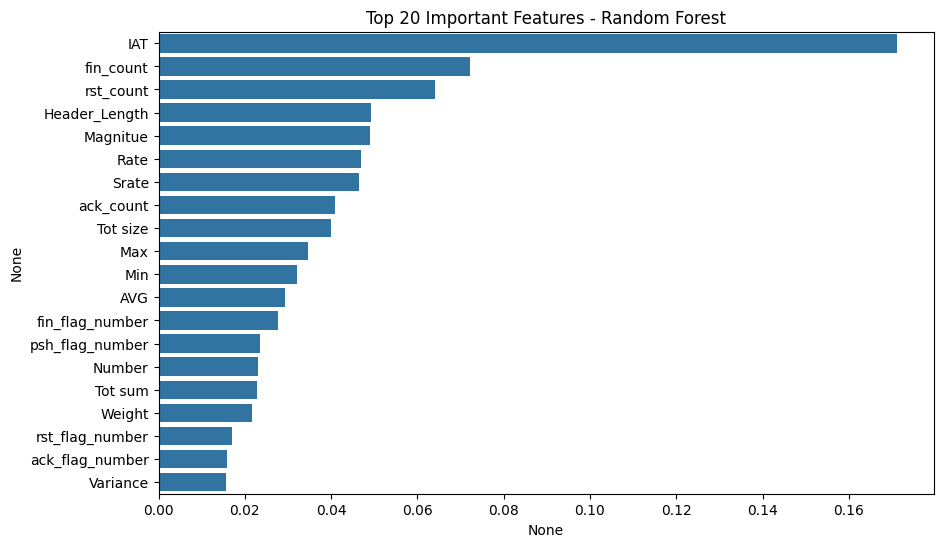

In [35]:
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp[:20], y=feat_imp.index[:20])
plt.title("Top 20 Important Features - Random Forest")
plt.show()

In [36]:
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42,
    n_jobs=4
)


In [37]:
xgb_clf.fit(X_train_scaledd, y_train_enc)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [38]:
y_pred = xgb_clf.predict(X_test_scaledd)

In [39]:
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

                precision    recall  f1-score   support

        Benign       0.97      0.99      0.98     12000
          DDoS       1.00      1.00      1.00      9335
           DoS       1.00      1.00      1.00     10246
          MQTT       1.00      1.00      1.00     12000
Reconnaissance       0.99      0.97      0.98     10805
      Spoofing       0.98      0.98      0.98     11993

      accuracy                           0.99     66379
     macro avg       0.99      0.99      0.99     66379
  weighted avg       0.99      0.99      0.99     66379



In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [41]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_enc, dtype=torch.long)

In [42]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [43]:
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

In [44]:
class OneDCNN(nn.Module):
    def __init__(self, input_len, num_classes):
        super(OneDCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.global_pool = nn.AdaptiveMaxPool1d(1)   # replaces GlobalMaxPooling1D
        self.fc1 = nn.Linear(128, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # x shape: (batch, seq_len, channels) → need to permute for Conv1d
        x = x.permute(0, 2, 1)
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.conv2(x))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x 

In [45]:
input_len = X_train_scaled.shape[1]
model = OneDCNN(input_len, num_classes).to(device)
print(model)

OneDCNN(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (global_pool): AdaptiveMaxPool1d(output_size=1)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [47]:
history = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "precision": [],
    "recall": [],
    "f1": []
}

In [48]:
num_epochs = 50

In [49]:
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    train_loss = running_loss / total
    train_acc = correct / total

    # --- Validation ---
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []  # <-- added

    with torch.no_grad():
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)

            # record loss
            loss = criterion(outputs, y_val)
            val_loss += loss.item() * X_val.size(0)

            _, predicted = torch.max(outputs, 1)
            val_total += y_val.size(0)
            val_correct += (predicted == y_val).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_val.cpu().numpy())

    val_loss /= val_total
    val_acc = val_correct / val_total

    # extra metrics
    precision = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")
    f1 = f1_score(all_labels, all_preds, average="macro")

    # Store metrics
    history["epoch"].append(epoch + 1)
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["precision"].append(precision)
    history["recall"].append(recall)
    history["f1"].append(f1)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
          f"F1: {f1:.4f}")


Epoch [1/50] - Train Loss: 0.6048, Train Acc: 0.7511 | Val Loss: 0.3890, Val Acc: 0.8056 | F1: 0.7866
Epoch [2/50] - Train Loss: 0.3744, Train Acc: 0.8197 | Val Loss: 0.3494, Val Acc: 0.8307 | F1: 0.8055
Epoch [3/50] - Train Loss: 0.3446, Train Acc: 0.8325 | Val Loss: 0.3244, Val Acc: 0.8435 | F1: 0.8287
Epoch [4/50] - Train Loss: 0.3256, Train Acc: 0.8415 | Val Loss: 0.3070, Val Acc: 0.8495 | F1: 0.8331
Epoch [5/50] - Train Loss: 0.3155, Train Acc: 0.8473 | Val Loss: 0.3066, Val Acc: 0.8547 | F1: 0.8434
Epoch [6/50] - Train Loss: 0.3081, Train Acc: 0.8489 | Val Loss: 0.3011, Val Acc: 0.8505 | F1: 0.8340
Epoch [7/50] - Train Loss: 0.3025, Train Acc: 0.8518 | Val Loss: 0.2952, Val Acc: 0.8593 | F1: 0.8437
Epoch [8/50] - Train Loss: 0.2988, Train Acc: 0.8529 | Val Loss: 0.3035, Val Acc: 0.8513 | F1: 0.8336
Epoch [9/50] - Train Loss: 0.2958, Train Acc: 0.8551 | Val Loss: 0.2910, Val Acc: 0.8578 | F1: 0.8463
Epoch [10/50] - Train Loss: 0.2927, Train Acc: 0.8557 | Val Loss: 0.2862, Val Acc:

In [50]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_val, y_val in test_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        outputs = model(X_val)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_val.cpu().numpy())

print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9125    0.9445    0.9282     12000
           1     0.7481    0.5281    0.6192      9335
           2     0.6606    0.8375    0.7386     10246
           3     0.9986    0.9845    0.9915     12000
           4     0.9922    0.9226    0.9562     10805
           5     0.9071    0.9456    0.9259     11993

    accuracy                         0.8733     66379
   macro avg     0.8699    0.8605    0.8599     66379
weighted avg     0.8781    0.8733    0.8711     66379



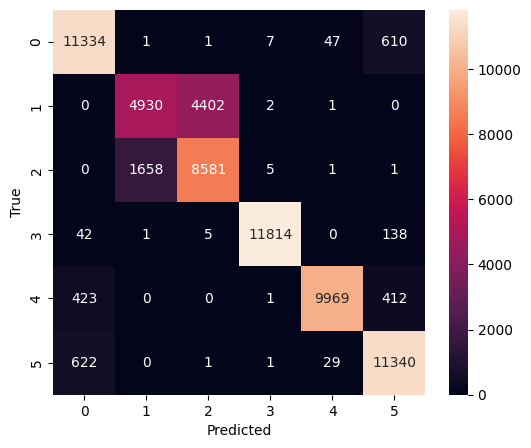

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [52]:
history

{'epoch': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 'train_loss': [0.6047567677966013,
  0.37443692588976946,
  0.3446185762416877,
  0.3255761999355422,
  0.31552701731949334,
  0.30811244054768366,
  0.30254874910702456,
  0.29884748978522013,
  0.2957902248455401,
  0.29268630067019685,
  0.2901284022613339,
  0.2879001541623857,
  0.2866779408514793,
  0.2830565172310856,
  0.28406519412914466,
  0.28038390304365274,
  0.2788936380122167,
  0.27694208242343826,
  0.2773625513026414,
  0.2746610599181909,
  0.27301104921058544,
  0.27291634266269854,
  0.2711213272732736,
  0.270259643582208,
  0.26926567639887306,
  0.26871957313449035,
  0.2679322058412809,
  0.2670324226481454,
  0.266375885306791,
  0.2656836571927221,
  0.2652794496

In [53]:
df = pd.DataFrame(history)

In [54]:
df.to_csv("../metrics/torch/1dcnn.csv", index=False)

In [55]:
torch.save(model.state_dict(), "../artifacts/torch/onedcnn_model_cuda.pth")

In [56]:
class CNN_LSTM(nn.Module):
    def __init__(self, input_len, num_classes):
        super(CNN_LSTM, self).__init__()
        
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
    
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        
        self.fc1 = nn.Linear(64, 128)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Input x: (batch, seq_len, 1)
        x = x.permute(0, 2, 1)                   # → (batch, 1, seq_len)
        x = torch.relu(self.bn1(self.conv1(x)))  # (batch, 64, L-2)
        x = torch.relu(self.conv2(x))            # (batch, 128, L-4)
        x = self.pool(x)                         # (batch, 128, (L-4)//2)
        
        # LSTM expects (batch, seq_len, features)
        x = x.permute(0, 2, 1)
        _, (h_n, _) = self.lstm(x)
        x = h_n[-1]                              # take last hidden state (batch, 64)
        
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x 

In [57]:
input_len = X_train_scaled.shape[1]
model = CNN_LSTM(input_len, num_classes).to(device)
print(model)

CNN_LSTM(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lstm): LSTM(128, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


In [58]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [59]:
history = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "precision": [],
    "recall": [],
    "f1": []
}

In [60]:
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, total = 0.0, 0, 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        total += y_batch.size(0)
        train_correct += (preds == y_batch).sum().item()
    
    avg_train_loss = train_loss / total
    train_acc = train_correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []   # <-- NEW

    with torch.no_grad():
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            
            # collect validation loss
            loss = criterion(outputs, y_val)
            val_loss += loss.item() * X_val.size(0)

            _, preds = torch.max(outputs, 1)
            val_total += y_val.size(0)
            val_correct += (preds == y_val).sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_val.cpu().numpy())

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total

    # Compute metrics
    precision = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")
    f1 = f1_score(all_labels, all_preds, average="macro")

    # Store
    history["epoch"].append(epoch + 1)
    history["train_loss"].append(avg_train_loss)     # <-- (fix) store avg, not sum
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["val_loss"].append(avg_val_loss)         # <-- NEW
    history["precision"].append(precision)           # <-- NEW
    history["recall"].append(recall)                 # <-- NEW
    history["f1"].append(f1)                         # <-- NEW

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f} | "
          f"F1: {f1:.4f}")


Epoch [1/50] | Train Loss: 0.5098, Train Acc: 0.7642 | Val Loss: 0.3449, Val Acc: 0.8196 | F1: 0.8050
Epoch [2/50] | Train Loss: 0.3405, Train Acc: 0.8251 | Val Loss: 0.3219, Val Acc: 0.8230 | F1: 0.7755
Epoch [3/50] | Train Loss: 0.3140, Train Acc: 0.8438 | Val Loss: 0.2884, Val Acc: 0.8552 | F1: 0.8416
Epoch [4/50] | Train Loss: 0.2968, Train Acc: 0.8524 | Val Loss: 0.2871, Val Acc: 0.8605 | F1: 0.8498
Epoch [5/50] | Train Loss: 0.2863, Train Acc: 0.8584 | Val Loss: 0.2737, Val Acc: 0.8595 | F1: 0.8488
Epoch [6/50] | Train Loss: 0.2812, Train Acc: 0.8600 | Val Loss: 0.2698, Val Acc: 0.8651 | F1: 0.8491
Epoch [7/50] | Train Loss: 0.2761, Train Acc: 0.8632 | Val Loss: 0.2669, Val Acc: 0.8677 | F1: 0.8573
Epoch [8/50] | Train Loss: 0.2733, Train Acc: 0.8647 | Val Loss: 0.2705, Val Acc: 0.8652 | F1: 0.8551
Epoch [9/50] | Train Loss: 0.2701, Train Acc: 0.8662 | Val Loss: 0.2638, Val Acc: 0.8689 | F1: 0.8589
Epoch [10/50] | Train Loss: 0.2678, Train Acc: 0.8669 | Val Loss: 0.2598, Val Acc:

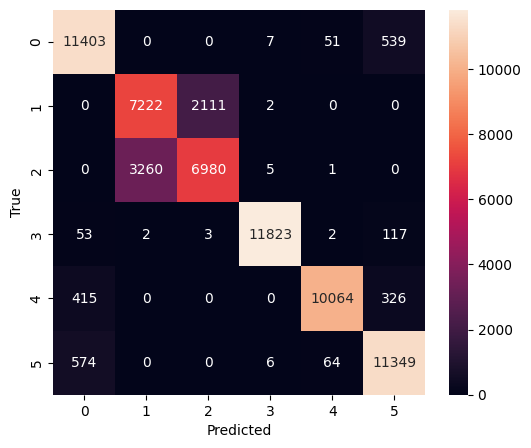

In [61]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [62]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_val, y_val in test_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        outputs = model(X_val)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_val.cpu().numpy())

print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9163    0.9503    0.9330     12000
           1     0.6889    0.7736    0.7288      9335
           2     0.7675    0.6812    0.7218     10246
           3     0.9983    0.9852    0.9917     12000
           4     0.9884    0.9314    0.9591     10805
           5     0.9204    0.9463    0.9332     11993

    accuracy                         0.8864     66379
   macro avg     0.8800    0.8780    0.8779     66379
weighted avg     0.8886    0.8864    0.8866     66379



In [63]:
df = pd.DataFrame(history)

In [64]:
df.to_csv("../metrics/torch/rclnet.csv", index=False)

In [65]:
torch.save(model.state_dict(), "../artifacts/torch/rclnet_cuda.pth")

In [66]:
class CNN_BiLSTM_Attention(nn.Module):
    def __init__(self, input_len, num_classes, lstm_hidden=64, num_heads=4):
        super(CNN_BiLSTM_Attention, self).__init__()
        
        # CNN feature extractor
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding='same')
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding='same')
        self.pool = nn.MaxPool1d(2)
        
        # BiLSTM block
        self.bilstm = nn.LSTM(
            input_size=128,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        # Multi-Head Self-Attention
        self.attention = nn.MultiheadAttention(embed_dim=2*lstm_hidden, num_heads=num_heads, batch_first=True)
        self.norm = nn.LayerNorm(2*lstm_hidden)

        # Dense layers
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(2*lstm_hidden, 128)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Input shape: (batch, seq_len, 1)
        x = x.permute(0, 2, 1)                 # (batch, 1, seq_len)
        x = torch.relu(self.conv1(x))          # (batch, 64, seq_len)
        x = torch.relu(self.conv2(x))          # (batch, 128, seq_len)
        x = self.pool(x)                       # (batch, 128, seq_len//2)
        
        # Prepare for LSTM: (batch, seq_len, features)
        x = x.permute(0, 2, 1)
        x, _ = self.bilstm(x)                  # (batch, seq_len//2, 2*lstm_hidden)
        
        # Multihead Self-Attention with residual connection
        attn_output, _ = self.attention(x, x, x)
        x = self.norm(x + attn_output)

        # Global average pooling over the sequence dimension
        x = x.permute(0, 2, 1)
        x = self.global_pool(x).squeeze(-1)    # (batch, 2*lstm_hidden)
        
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)                        # logits
        return x


In [67]:
input_len = X_train_scaled.shape[1]
model = CNN_BiLSTM_Attention(input_len, num_classes).to(device)
print(model)

CNN_BiLSTM_Attention(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=same)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=same)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bilstm): LSTM(128, 64, batch_first=True, bidirectional=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (global_pool): AdaptiveAvgPool1d(output_size=1)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


In [68]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [69]:
history = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "precision": [],
    "recall": [],
    "f1": []
}

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct, total = 0.0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        total += y_batch.size(0)
        train_correct += (preds == y_batch).sum().item()
    
    avg_train_loss = train_loss / total
    train_acc = train_correct / total

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X_val, y_val in test_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)

            val_loss += loss.item() * X_val.size(0)
            _, preds = torch.max(outputs, 1)

            val_total += y_val.size(0)
            val_correct += (preds == y_val).sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_val.cpu().numpy())

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total

    # Compute metrics
    precision = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")
    f1 = f1_score(all_labels, all_preds, average="macro")

    # Store all of them
    history["epoch"].append(epoch + 1)
    history["train_loss"].append(avg_train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(avg_val_loss)
    history["val_acc"].append(val_acc)
    history["precision"].append(precision)
    history["recall"].append(recall)
    history["f1"].append(f1)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f} | "
          f"F1: {f1:.4f}")

Epoch [1/50] | Train Loss: 0.4566 | Train Acc: 0.7789 | Val Loss: 0.3312 | Val Acc: 0.8352 | F1: 0.8233
Epoch [2/50] | Train Loss: 0.3263 | Train Acc: 0.8353 | Val Loss: 0.3281 | Val Acc: 0.8252 | F1: 0.8063
Epoch [3/50] | Train Loss: 0.3146 | Train Acc: 0.8469 | Val Loss: 0.2973 | Val Acc: 0.8547 | F1: 0.8445
Epoch [4/50] | Train Loss: 0.2925 | Train Acc: 0.8564 | Val Loss: 0.2845 | Val Acc: 0.8564 | F1: 0.8458
Epoch [5/50] | Train Loss: 0.2841 | Train Acc: 0.8589 | Val Loss: 0.3009 | Val Acc: 0.8579 | F1: 0.8465
Epoch [6/50] | Train Loss: 0.2805 | Train Acc: 0.8611 | Val Loss: 0.2739 | Val Acc: 0.8594 | F1: 0.8386
Epoch [7/50] | Train Loss: 0.2742 | Train Acc: 0.8639 | Val Loss: 0.2632 | Val Acc: 0.8679 | F1: 0.8577
Epoch [8/50] | Train Loss: 0.2705 | Train Acc: 0.8660 | Val Loss: 0.2616 | Val Acc: 0.8681 | F1: 0.8580
Epoch [9/50] | Train Loss: 0.2676 | Train Acc: 0.8666 | Val Loss: 0.2617 | Val Acc: 0.8678 | F1: 0.8579
Epoch [10/50] | Train Loss: 0.2645 | Train Acc: 0.8679 | Val Los

In [70]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_val, y_val in test_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        outputs = model(X_val)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_val.cpu().numpy())

print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9302    0.9377    0.9340     12000
           1     0.7351    0.5766    0.6463      9335
           2     0.6774    0.8105    0.7380     10246
           3     0.9965    0.9867    0.9916     12000
           4     0.9881    0.9297    0.9580     10805
           5     0.9077    0.9577    0.9320     11993

    accuracy                         0.8785     66379
   macro avg     0.8725    0.8665    0.8666     66379
weighted avg     0.8811    0.8785    0.8772     66379



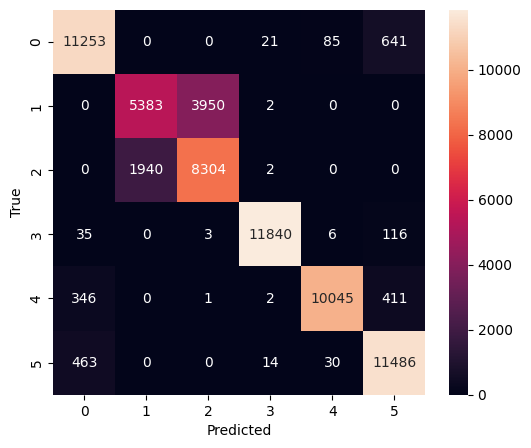

In [71]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [72]:
df = pd.DataFrame(history)
df.to_csv("../metrics/torch/rclnet-attn.csv", index=False)
torch.save(model.state_dict(), "../artifacts/torch/rclnet-attn_cuda.pth")

In [73]:
import torch.nn.functional as F

In [74]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]


# -------------------------------
# Residual Conv1D Block
# -------------------------------
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding="same")
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding="same")
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.shortcut = (
            nn.Conv1d(in_channels, out_channels, kernel_size=1)
            if in_channels != out_channels else nn.Identity()
        )

    def forward(self, x):
        residual = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out


# -------------------------------
# Advanced Residual + BiLSTM + Attention Model
# -------------------------------
class RCLNet_Attn_Pro(nn.Module):
    def __init__(self, input_features, num_classes, max_len=None):
        super(RCLNet_Attn_Pro, self).__init__()
        self.use_pos_enc = max_len is not None
        if self.use_pos_enc:
            self.pos_enc = PositionalEncoding(d_model=input_features, max_len=max_len)

        # CNN residual encoder
        self.res1 = ResidualBlock(1, 64)
        self.res2 = ResidualBlock(64, 128)
        self.pool = nn.MaxPool1d(2)

        # BiLSTM + MultiHeadAttention
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, batch_first=True, bidirectional=True)
        self.attn = nn.MultiheadAttention(embed_dim=128, num_heads=4, dropout=0.2, batch_first=True)
        self.norm = nn.LayerNorm(128)

        # Dense classifier
        self.fc1 = nn.Linear(128, 256)
        self.drop = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Input: (batch, seq_len, features)
        if self.use_pos_enc:
            x = self.pos_enc(x)

        # CNN expects (batch, channels, seq_len)
        x = x.permute(0, 2, 1)  # (B, F, T)
        x = self.res1(x)
        x = self.res2(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)  # (B, T, F)

        # BiLSTM + MultiHeadAttention
        x, _ = self.lstm(x)
        attn_out, _ = self.attn(x, x, x)
        x = self.norm(x + attn_out)

        # Global average pooling (mean over sequence)
        x = x.mean(dim=1)

        # Dense classifier
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
if X_train_t.dim() == 4:
    X_train_t = X_train_t.squeeze(-1)
elif X_train_t.dim() == 2:
    X_train_t = X_train_t.unsqueeze(-1)

y_train_t = torch.tensor(y_train_enc, dtype=torch.long)

X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
if X_test_t.dim() == 4:
    X_test_t = X_test_t.squeeze(-1)
elif X_test_t.dim() == 2:
    X_test_t = X_test_t.unsqueeze(-1)

y_test_t = torch.tensor(y_test_enc, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=64, shuffle=False)

In [76]:
input_features = 1              # last dim from (seq_len, features)
seq_len = X_train_scaled.shape[1]
num_classes = len(le.classes_)

In [77]:
model = RCLNet_Attn_Pro(input_features, num_classes, max_len=seq_len).to(device)
print(sum(p.numel() for p in model.parameters()) / 1e6, "M parameters")

0.296006 M parameters


In [78]:
dummy = torch.randn(8, seq_len, input_features).to(device)
out = model(dummy)
print(out.shape)

torch.Size([8, 6])


In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [80]:
seq_len = X_train_scaled.shape[1]
num_classes = len(le.classes_)

In [81]:
model = RCLNet_Attn_Pro(input_features=1, num_classes=num_classes, max_len=seq_len).to(device)

In [82]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [83]:
history = {
    "epoch": [],
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
    "precision": [],
    "recall": [],
    "f1": []
}

In [84]:
EPOCHS = 50
for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # --- Validation ---
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    all_preds, all_labels = [], []     # NEW

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, preds = torch.max(outputs, 1)

            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    val_loss /= val_total
    val_acc = val_correct / val_total

    # Extra Metrics
    precision = precision_score(all_labels, all_preds, average="macro")
    recall = recall_score(all_labels, all_preds, average="macro")
    f1 = f1_score(all_labels, all_preds, average="macro")

    # Store metrics
    history["epoch"].append(epoch+1)
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["precision"].append(precision)
    history["recall"].append(recall)
    history["f1"].append(f1)

    print(f"Epoch [{epoch+1}/{EPOCHS}] | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
          f"F1: {f1:.4f}")

Epoch [1/50] | Train Loss: 0.3330, Train Acc: 0.8297 | Val Loss: 0.2806, Val Acc: 0.8563 | F1: 0.8419
Epoch [2/50] | Train Loss: 0.2874, Train Acc: 0.8550 | Val Loss: 0.2835, Val Acc: 0.8496 | F1: 0.8310
Epoch [3/50] | Train Loss: 0.2754, Train Acc: 0.8613 | Val Loss: 0.2640, Val Acc: 0.8664 | F1: 0.8561
Epoch [4/50] | Train Loss: 0.2689, Train Acc: 0.8646 | Val Loss: 0.2642, Val Acc: 0.8659 | F1: 0.8465
Epoch [5/50] | Train Loss: 0.2625, Train Acc: 0.8677 | Val Loss: 0.2539, Val Acc: 0.8723 | F1: 0.8617
Epoch [6/50] | Train Loss: 0.2593, Train Acc: 0.8690 | Val Loss: 0.2698, Val Acc: 0.8624 | F1: 0.8425
Epoch [7/50] | Train Loss: 0.2560, Train Acc: 0.8711 | Val Loss: 0.2589, Val Acc: 0.8732 | F1: 0.8581
Epoch [8/50] | Train Loss: 0.2528, Train Acc: 0.8729 | Val Loss: 0.2501, Val Acc: 0.8737 | F1: 0.8579
Epoch [9/50] | Train Loss: 0.2513, Train Acc: 0.8733 | Val Loss: 0.2500, Val Acc: 0.8730 | F1: 0.8613
Epoch [10/50] | Train Loss: 0.2496, Train Acc: 0.8741 | Val Loss: 0.2476, Val Acc:

In [85]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for X_val, y_val in test_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        outputs = model(X_val)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_val.cpu().numpy())

print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9183    0.9522    0.9349     12000
           1     0.7030    0.6210    0.6595      9335
           2     0.6877    0.7607    0.7223     10246
           3     0.9966    0.9870    0.9918     12000
           4     0.9801    0.9393    0.9593     10805
           5     0.9302    0.9398    0.9350     11993

    accuracy                         0.8780     66379
   macro avg     0.8693    0.8667    0.8671     66379
weighted avg     0.8788    0.8780    0.8776     66379



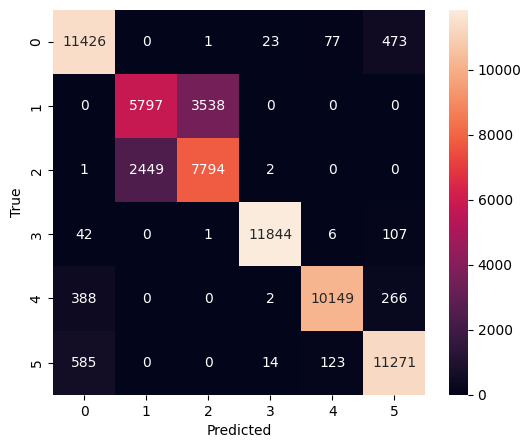

In [86]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [87]:
df = pd.DataFrame(history)
df.to_csv("../metrics/torch/rclnet-multiheadselfattn.csv", index=False)
torch.save(model.state_dict(), "../artifacts/torch/rclnet-MULTI_cuda.pth")